In [1]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import pytorch_lightning as pl

random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE = 128
AVAIL_GPU = min(1, torch.cuda.device_count())
NUM_WORKERS = int(os.cpu_count() / 2) # type: ignore

In [2]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir = "./data",
                batch_size = BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307), (0.3081))
            ]
        )

    def prepare_data(self) -> None:
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)


In [3]:
mnist_obj = MNISTDataModule()
mnist_obj.setup("fit")

In [4]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1,10,kernel_size=5)
        self.conv2 = nn.Conv2d(10,20,kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,1)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(F.max_pool2d(x, 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
        # Flatten the tensor so it can be fed into the FC layer
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7) # [n, 16, 34, 34]

    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x)
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7) #256

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x)
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)


In [ ]:
import pytorch_lightning as pl
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()  # saves arguments into self.hparams
        self.generator = Generator(self.hparams.latent_dim)
        self.discriminator = Discriminator()

        self.validation_z = torch.randn(6, self.hparams.latent_dim)
        self.automatic_optimization = False  # we want manual optimizer steps

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        batch_size = real_imgs.size(0)
        device = real_imgs.device

        # Sample noise
        z = torch.randn(batch_size, self.hparams.latent_dim, device=device)

        # Get optimizers manually
        opt_g, opt_d = self.optimizers()

        # === Train Generator ===
        fake_imgs = self(z)
        y_hat = self.discriminator(fake_imgs)
        y_real = torch.ones(batch_size, 1, device=device)

        g_loss = self.adversarial_loss(y_hat, y_real)
        opt_g.zero_grad()
        self.manual_backward(g_loss)
        opt_g.step()

        # === Train Discriminator ===
        y_hat_real = self.discriminator(real_imgs)
        y_hat_fake = self.discriminator(fake_imgs.detach())

        y_real = torch.ones(batch_size, 1, device=device)
        y_fake = torch.zeros(batch_size, 1, device=device)

        d_loss_real = self.adversarial_loss(y_hat_real, y_real)
        d_loss_fake = self.adversarial_loss(y_hat_fake, y_fake)
        d_loss = (d_loss_real + d_loss_fake) / 2

        opt_d.zero_grad()
        self.manual_backward(d_loss)
        opt_d.step()

        self.log("g_loss", g_loss, prog_bar=True, on_step=True, on_epoch=True)
        self.log("d_loss", d_loss, prog_bar=True, on_step=True, on_epoch=True)

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
        return [opt_g, opt_d], []

    def plot_imgs(self):
        z = self.validation_z.to(self.device)
        sample_imgs = self(z).cpu()
        print("EPOCH:", self.current_epoch)
        fig = plt.figure(figsize=(8, 4))
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i + 1)
            plt.tight_layout()
            plt.imshow(sample_imgs[i, 0, :, :].detach().numpy(), cmap='gray_r', interpolation='none')
            plt.title("Generated")
            plt.axis('off')
        plt.show()

    def on_train_epoch_end(self):
        self.plot_imgs()


In [6]:
dm = MNISTDataModule()
model = GAN()

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/guptayas/.pyenv/versions/py31013/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 358 K  | train
1 | discriminator | Discriminator | 21.4 K | train
--------------------------------------------------------
379 K     Trainable params
0         Non-trainable params
379 K     Total params
1.520     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
/Users/guptayas/.pyenv/versions/py31013/lib/python3.10/si

Epoch 0: 100%|██████████| 430/430 [00:14<00:00, 29.49it/s, v_num=18, g_loss_step=3.680, d_loss_step=0.0492, g_loss_epoch=1.910, d_loss_epoch=0.213]running
EPOCH: 0


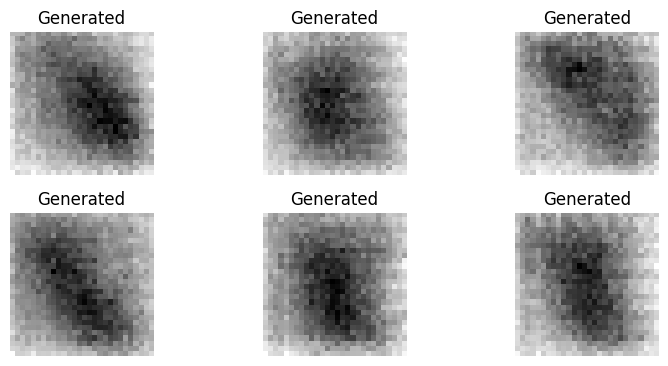

Epoch 1: 100%|██████████| 430/430 [00:10<00:00, 42.64it/s, v_num=18, g_loss_step=8.250, d_loss_step=0.0183, g_loss_epoch=5.940, d_loss_epoch=0.0414]running
EPOCH: 1


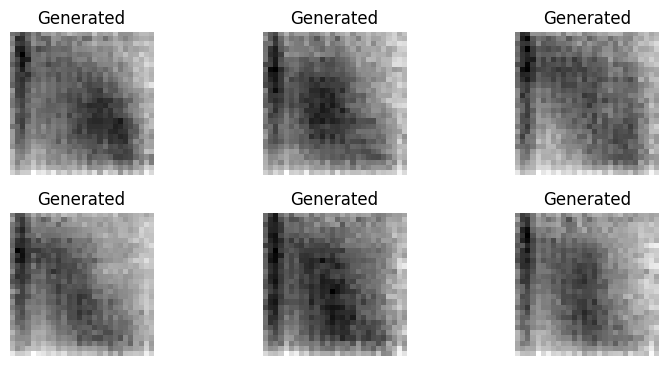

Epoch 2: 100%|██████████| 430/430 [00:09<00:00, 44.99it/s, v_num=18, g_loss_step=3.010, d_loss_step=0.114, g_loss_epoch=7.150, d_loss_epoch=0.0759] running
EPOCH: 2


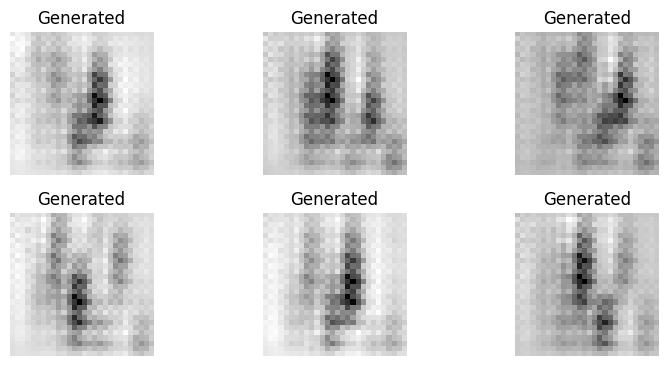

Epoch 3: 100%|██████████| 430/430 [00:09<00:00, 45.47it/s, v_num=18, g_loss_step=2.680, d_loss_step=0.215, g_loss_epoch=2.380, d_loss_epoch=0.220] running
EPOCH: 3


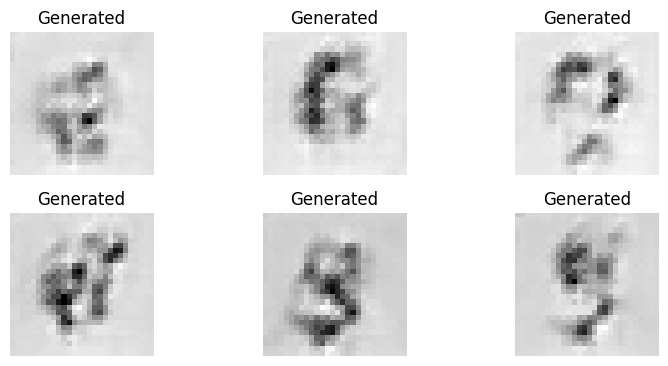

Epoch 4: 100%|██████████| 430/430 [00:09<00:00, 45.25it/s, v_num=18, g_loss_step=2.290, d_loss_step=0.254, g_loss_epoch=2.260, d_loss_epoch=0.261]running
EPOCH: 4


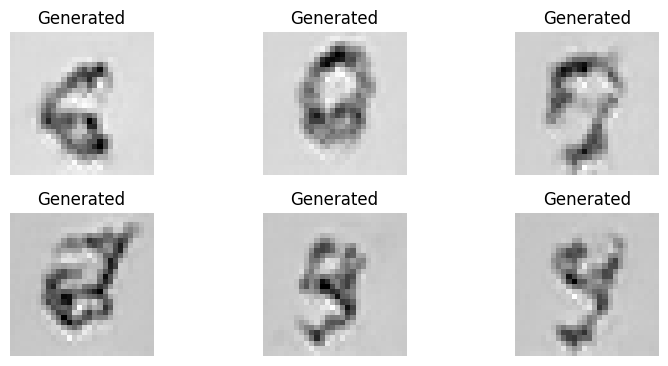

Epoch 5: 100%|██████████| 430/430 [00:09<00:00, 44.99it/s, v_num=18, g_loss_step=2.160, d_loss_step=0.278, g_loss_epoch=2.260, d_loss_epoch=0.257]running
EPOCH: 5


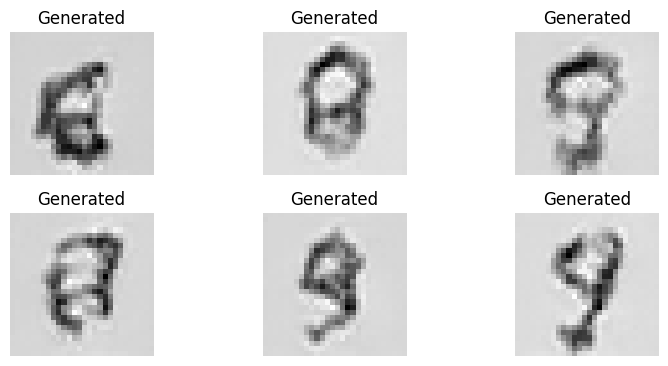

Epoch 6: 100%|██████████| 430/430 [00:09<00:00, 43.69it/s, v_num=18, g_loss_step=2.580, d_loss_step=0.235, g_loss_epoch=2.310, d_loss_epoch=0.250]running
EPOCH: 6


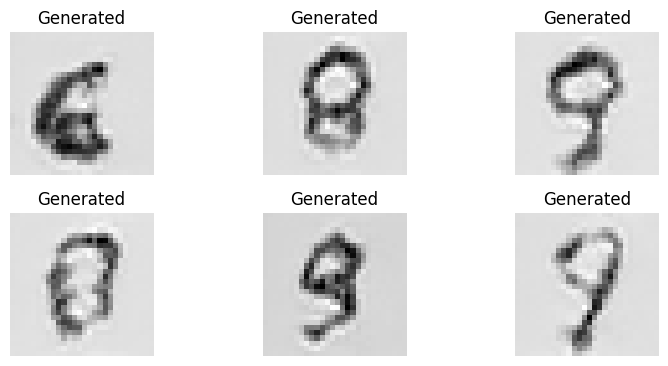

Epoch 7: 100%|██████████| 430/430 [00:09<00:00, 44.16it/s, v_num=18, g_loss_step=2.620, d_loss_step=0.234, g_loss_epoch=2.270, d_loss_epoch=0.263]running
EPOCH: 7


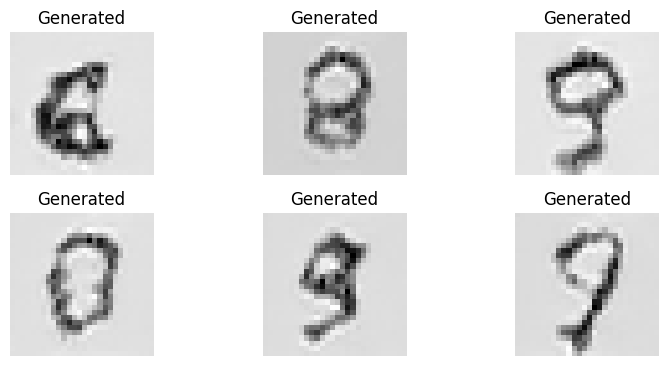

Epoch 8: 100%|██████████| 430/430 [00:09<00:00, 44.78it/s, v_num=18, g_loss_step=2.550, d_loss_step=0.249, g_loss_epoch=2.220, d_loss_epoch=0.275]running
EPOCH: 8


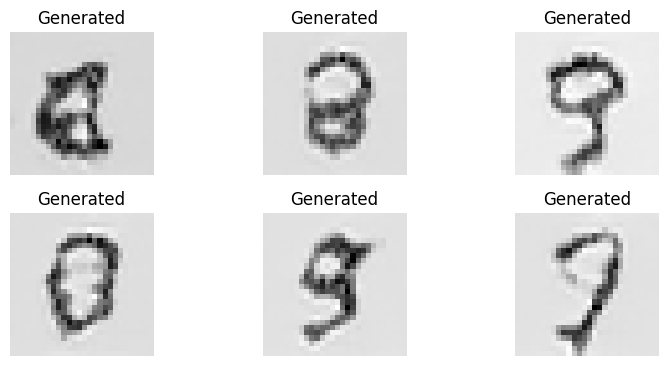

Epoch 9: 100%|██████████| 430/430 [00:09<00:00, 44.73it/s, v_num=18, g_loss_step=1.980, d_loss_step=0.344, g_loss_epoch=2.130, d_loss_epoch=0.293]running
EPOCH: 9


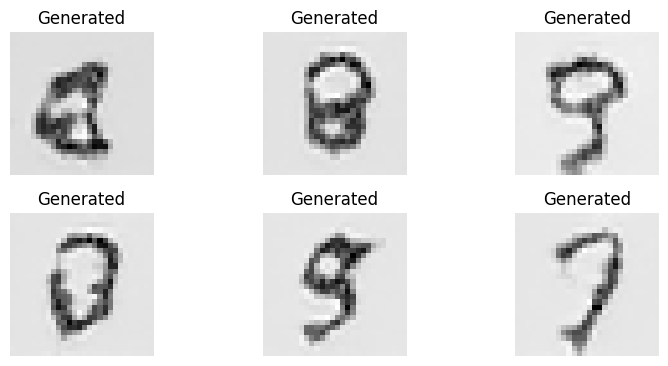

Epoch 10: 100%|██████████| 430/430 [00:09<00:00, 44.76it/s, v_num=18, g_loss_step=1.770, d_loss_step=0.280, g_loss_epoch=2.080, d_loss_epoch=0.301]running
EPOCH: 10


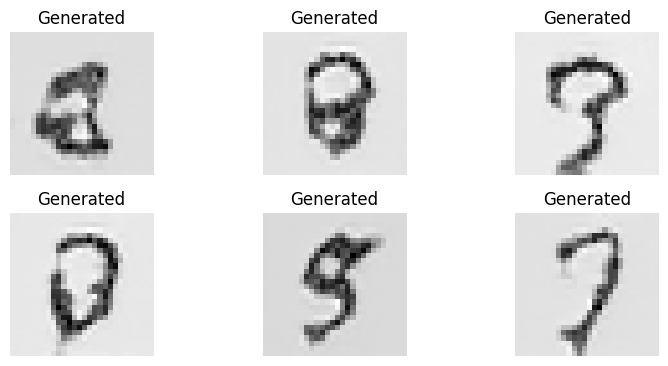

Epoch 11: 100%|██████████| 430/430 [00:09<00:00, 45.29it/s, v_num=18, g_loss_step=1.800, d_loss_step=0.292, g_loss_epoch=2.010, d_loss_epoch=0.316]running
EPOCH: 11


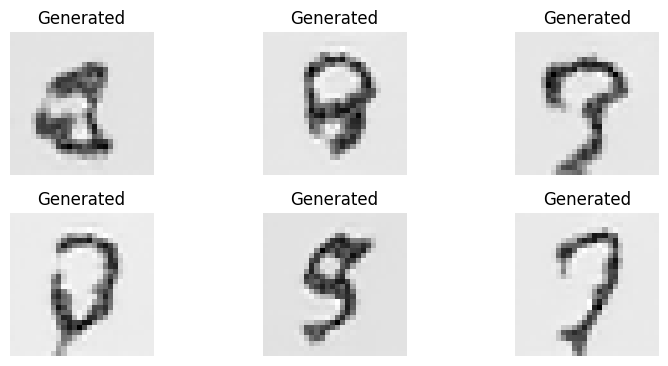

Epoch 12: 100%|██████████| 430/430 [00:09<00:00, 44.87it/s, v_num=18, g_loss_step=1.680, d_loss_step=0.364, g_loss_epoch=1.960, d_loss_epoch=0.324]running
EPOCH: 12


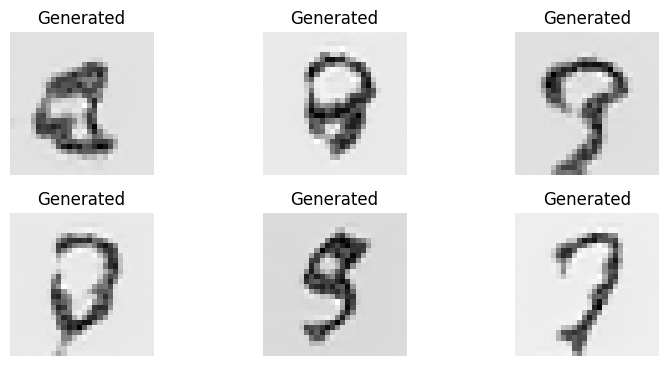

Epoch 13: 100%|██████████| 430/430 [00:09<00:00, 43.55it/s, v_num=18, g_loss_step=2.060, d_loss_step=0.321, g_loss_epoch=1.920, d_loss_epoch=0.333]running
EPOCH: 13


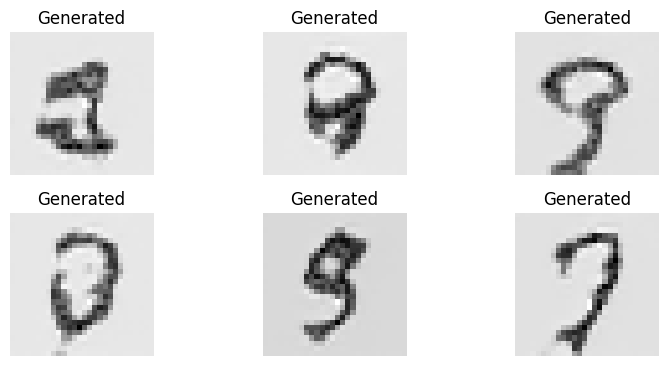

Epoch 14: 100%|██████████| 430/430 [00:09<00:00, 44.02it/s, v_num=18, g_loss_step=1.680, d_loss_step=0.365, g_loss_epoch=1.880, d_loss_epoch=0.344]running
EPOCH: 14


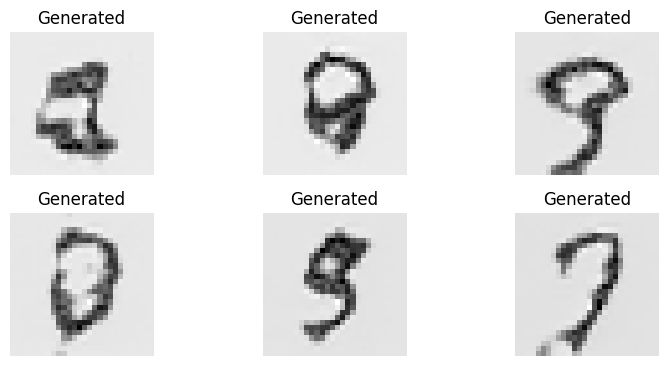

Epoch 15: 100%|██████████| 430/430 [00:09<00:00, 43.43it/s, v_num=18, g_loss_step=1.680, d_loss_step=0.325, g_loss_epoch=1.820, d_loss_epoch=0.356]running
EPOCH: 15


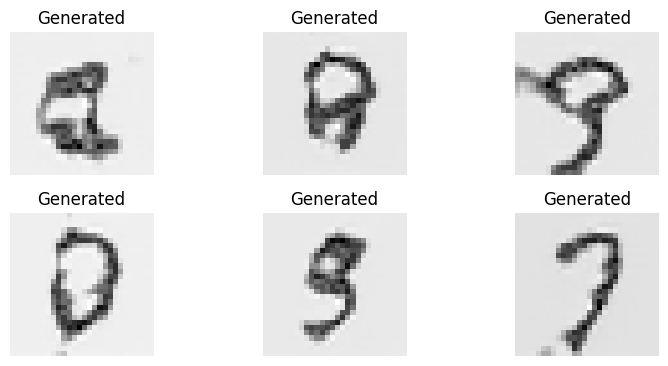

Epoch 16: 100%|██████████| 430/430 [00:09<00:00, 43.31it/s, v_num=18, g_loss_step=1.510, d_loss_step=0.398, g_loss_epoch=1.780, d_loss_epoch=0.368]running
EPOCH: 16


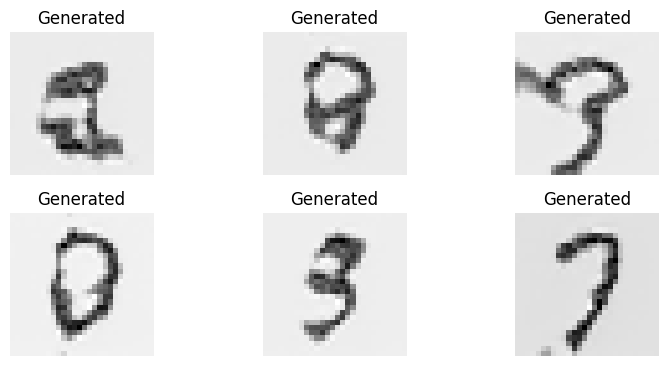

Epoch 17: 100%|██████████| 430/430 [00:09<00:00, 43.73it/s, v_num=18, g_loss_step=1.870, d_loss_step=0.321, g_loss_epoch=1.720, d_loss_epoch=0.378]running
EPOCH: 17


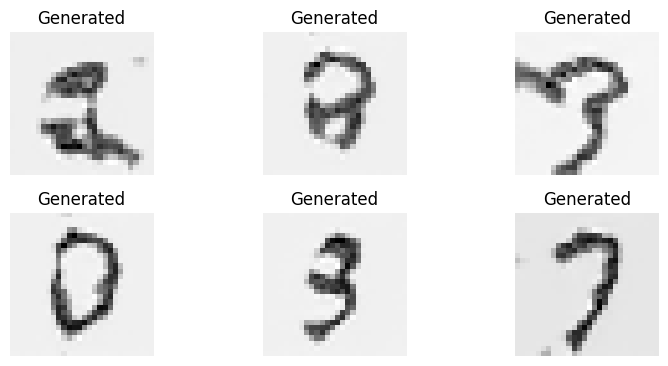

Epoch 18: 100%|██████████| 430/430 [00:10<00:00, 42.24it/s, v_num=18, g_loss_step=1.550, d_loss_step=0.444, g_loss_epoch=1.670, d_loss_epoch=0.389]running
EPOCH: 18


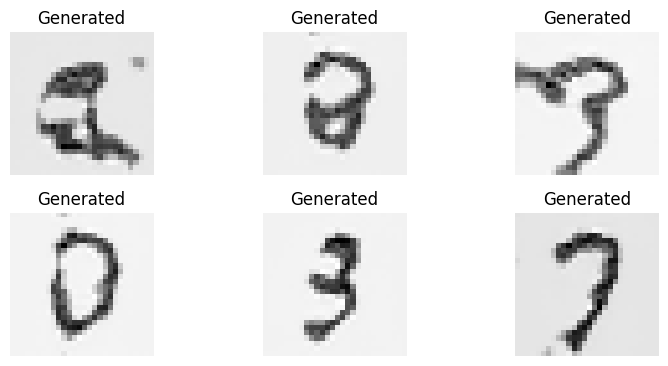

Epoch 19: 100%|██████████| 430/430 [00:10<00:00, 42.49it/s, v_num=18, g_loss_step=2.120, d_loss_step=0.474, g_loss_epoch=1.660, d_loss_epoch=0.389]running
EPOCH: 19


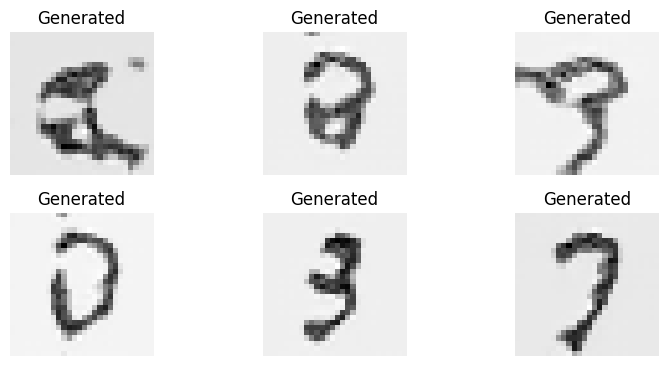

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 430/430 [00:10<00:00, 41.75it/s, v_num=18, g_loss_step=2.120, d_loss_step=0.474, g_loss_epoch=1.660, d_loss_epoch=0.389]


In [7]:
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, dm)